# <center>TP6 - Bagging, Boosting, Random Forests
***

In [1]:
import numpy as np

from sklearn import preprocessing
from sklearn.datasets import load_boston, load_diabetes, load_iris, load_digits
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import zero_one_loss
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

## <center> - Bagging -
***

### Question 1.

Mettez en œuvre le Bagging avec des arbres de profondeur 1 (en Anglais stumps), puis avec des arbres plus profonds.

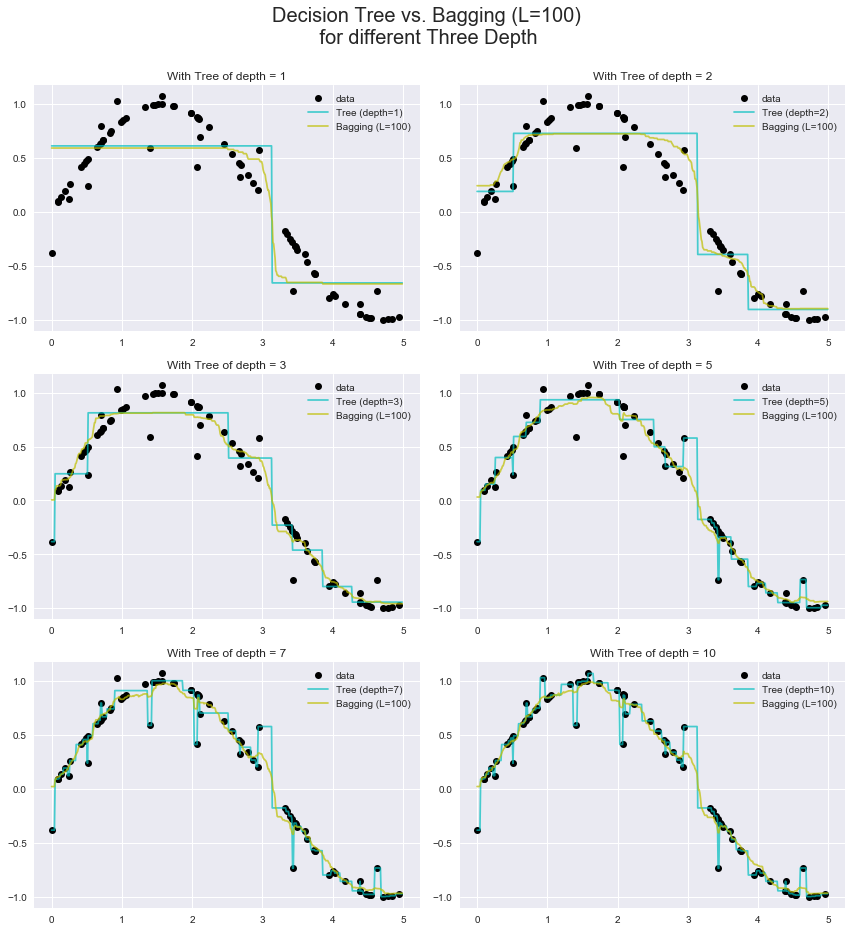

In [2]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))

n_estimators = 100 # L in the text
tree_max_depth_range = [1, 2, 3, 5, 7, 10]


fig = plt.figure(figsize=(12, 24))

for i, tree_max_depth in enumerate(tree_max_depth_range):
    # TODO Define the DecisionTree and Bagging regressor
    tree = DecisionTreeRegressor(max_depth=tree_max_depth)
    tree.fit(X, y)
    bagging = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators, max_samples=0.3)
    bagging.fit(X, y)
    
    # Predict
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_tree = tree.predict(X_test)
    y_bagging = bagging.predict(X_test)
    
    # Plot the results
    plt.subplot(len(tree_max_depth_range), 2, i+1)
    plt.plot(X, y, 'o', c="k", label="data")
    
    # TODO Add plots for Bagging/Tree
    plt.plot(X_test, y_tree, '-', c="c", label="Tree (depth="+str(tree_max_depth)+")", alpha=0.7)
    plt.plot(X_test, y_bagging, '-', c="y", label="Bagging (L="+str(n_estimators)+")", alpha=0.7)
    plt.legend(loc=1, numpoints=1)
    plt.title("With Tree of depth = "+str(tree_max_depth), fontsize=12)

plt.suptitle('Decision Tree vs. Bagging (L=100)\n \
for different Three Depth', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

### Question 2.

Illustrer graphiquement le rôle de L ainsi que de la profondeur des arbres (max_depth).

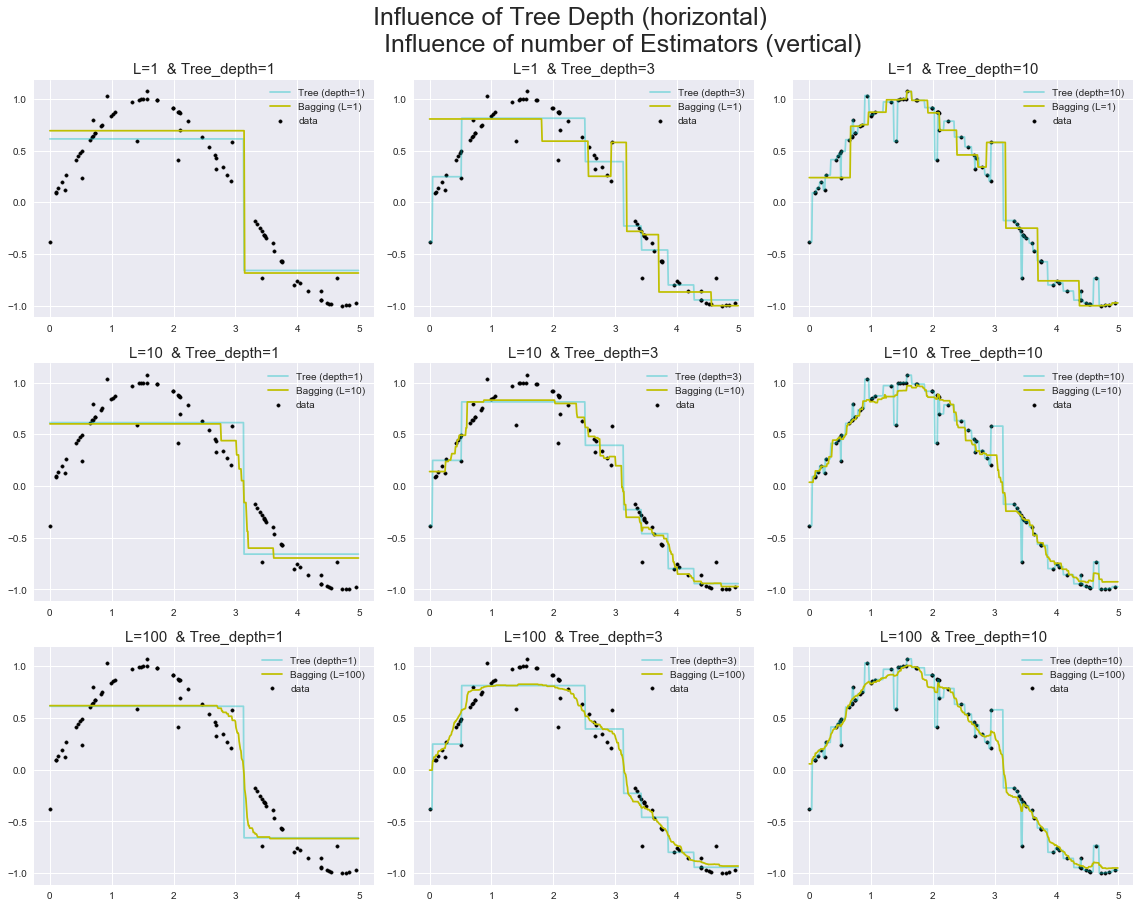

In [3]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))

n_estimators_range = [1, 10, 100]
tree_max_depth_range = [1, 3, 10]

fig, axs = plt.subplots(3, 3, figsize=(16, 12)) #, sharex=True, sharey=True)

for i, n_estimators in enumerate(n_estimators_range):
    for j, tree_max_depth in enumerate(tree_max_depth_range):
        # TODO Define the DecisionTree and Bagging regressor
        tree = DecisionTreeRegressor(max_depth=tree_max_depth)
        tree.fit(X, y)
        bagging = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators, max_samples=0.3)
        bagging.fit(X, y)
        
        # Predict
        X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
        y_tree = tree.predict(X_test)
        y_bagging = bagging.predict(X_test)
        
        # Plot the results
        axs[i, j].scatter(X, y, c="k", s=12, label="data")
        #plt.subplot(len(tree_max_depth_range), 3, i+1)
        #plt.plot(X, y, 'o', c="k", label="data")
        
        # TODO Add plots for Bagging/Tree
        axs[i, j].plot(X_test, y_tree, '-', c="c", label="Tree (depth="+str(tree_max_depth)+")", alpha=0.4)
        axs[i, j].plot(X_test, y_bagging, '-', c="y", label="Bagging (L="+str(n_estimators)+")", alpha=1.0)
        axs[i, j].legend(loc=1, numpoints=1)
        axs[i, j].set_title("L="+str(n_estimators)+"  & Tree_depth="+str(tree_max_depth), fontsize=15)

plt.suptitle('Influence of Tree Depth (horizontal)\n \
              Influence of number of Estimators (vertical)', fontsize=25, y=1.05)
plt.tight_layout()
plt.subplots_adjust()
plt.show()

> Plus le nombre d'estimateurs $L$ est grand, plus la variance diminue.  

> Plus la profondeur des arbres est grande, plus le biais diminue (mais au risque d'over-fitter).

### Question 3.

A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le bagging réduit
leur variance ?

> Pour répondre à cette question, nous allons répéter 20 Arbres de Décision et 20 Bagging et en faire la moyenne.
> Nous afficherons ensuite pour chacun des deux modèles (Arbre et Bagging) :
- Les données ainsi que les prédictions faites par le modèle
- La variance des predictions

In regression, the expected MSE of an estimator can be decomposed in terms of bias, variance and noise.

See below :

* model: 20 Tree Regressors (with pure nodes)
 error(=0.0348) = bias^2(=0.0009) + var(=0.0175) + noise(=0.0153)

* model: 20 Bagging on 50 Tree Regressors
 error(=0.0209) = bias^2(=0.0010) + var(=0.0034) + noise(=0.0153)



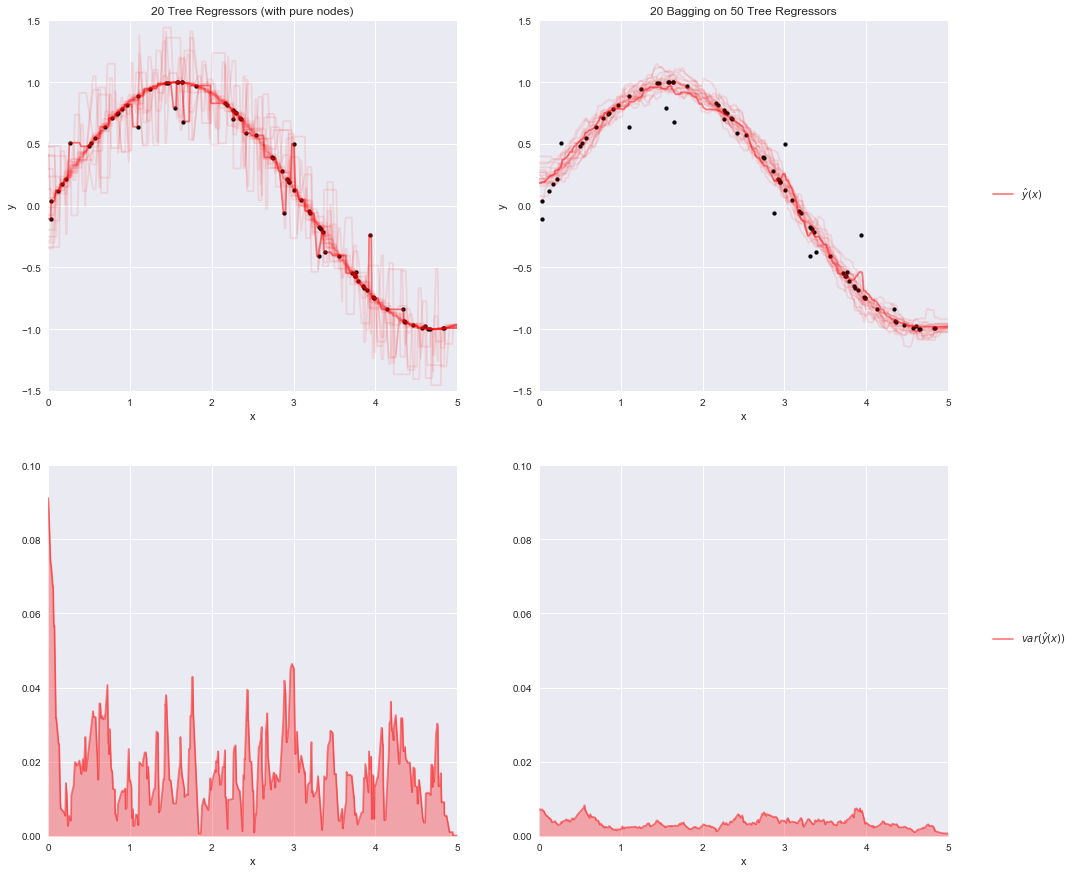

In [4]:
def f(x):
    x = x.ravel()
    return np.sin(x)

def generate(n_samples, n_repeat=1):
    rng = np.random.RandomState()
    X = np.sort(5 * rng.rand(n_samples))
    noise = n_samples // 5
    if n_repeat == 1:
        y = f(X)
        y[::5] += 1 * (0.5 - rng.rand(noise)) 
    else:
        y = np.zeros((n_samples, n_repeat))
        
        for i in range(n_repeat):
            y[:, i] = f(X)
            y[::5, i] += 1 * (0.5 - rng.rand(noise)) 
    X = X.reshape((n_samples, 1))
    return X, y


# Settings
n_train = 80        # Size of the training set
n_test = 500       # Size of the test set
n_repeat = 20       # Number of iterations for computing expectations

# Generate data
X_train = []
y_train = []

for _ in range(n_repeat):
    X, y = generate(n_samples=n_train)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, n_repeat=n_repeat)

estimators = [("20 Tree Regressors (with pure nodes)",
               DecisionTreeRegressor(min_samples_leaf=1)),
              ("20 Bagging on 50 Tree Regressors",
               BaggingRegressor(
                   DecisionTreeRegressor(min_samples_leaf=1),
                   n_estimators=50,
                   # The number of samples to draw from X to train each base estimator.
                   max_samples=0.3,
                   # Whether samples are drawn with replacement (True) or not (False).
                   bootstrap=True))]

n_estimators=len(estimators)

plt.figure(figsize = (20, 15))

print("In regression, the expected MSE of an estimator"
      " can be decomposed in terms of bias, variance and noise.\n")
print("See below :\n")

# Loop over estimators to compare.
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions.
    y_predict=np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i]=estimator.predict(X_test)

    if n == 1:
        temp=y_predict

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error=np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_predict[:, i] - y_test[:, j]) ** 2

    y_error /= (n_repeat ** 2)

    y_bias=(f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var=np.var(y_predict, axis = 1)
    y_noise=np.var(y_test, axis = 1)

    print("* model: {0}\n error(={1:.4f})"
          " = bias^2(={2:.4f})"
          " + var(={3:.4f})"
          " + noise(={4:.4f})\n".format(name, np.mean(y_error),
                                        np.mean(y_bias),
                                        np.mean(y_var),
                                        np.mean(y_noise)))

    # Plot figures.
    plt.subplot(2, n_estimators, n + 1)
    plt.title(name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, 5])
    plt.ylim([-1.5, 1.5])

    plt.scatter(X_train[0], y_train[0], color='k', s=15)

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], color='r', alpha=0.5, label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], color='r', alpha=0.1)

    if n == n_estimators - 1:
        plt.legend(loc = (1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_var,
             color='r', alpha=0.5,
             label="$var(\hat{y}(x))$")
    plt.fill_between(X_test.ravel(), y_var, 0,
                     color='r', alpha=0.3)

    plt.xlabel('x')
    plt.xlim([0, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

> Après avoir fait la moyenne sur 20 DecisionTrees et sur 20 Bagging, on peut constater que :
- Le biais est sensiblement similaire entre les 2 modèles
- Par contre, le bagging a fortement réduit la variance.  
On peut d'ailleurs le visualiser facilement quand on compare le comportement des deux modèles sur les outliers :  
==> Avec le Bagging, les prédictions sont beaucoup moins sensibles aux outliers.

### Question 4. & Question 5.

En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage.  
  
Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons bootstrap.
> Pour cela, parmi les paramètres du $BaggingRegressor$ :  
- Pour sous-échantilloner : $max\_samples < 1.0$  (nous prendrons $0.3$)
- Pour faire le tirage sans remise : $bootstrap = False$

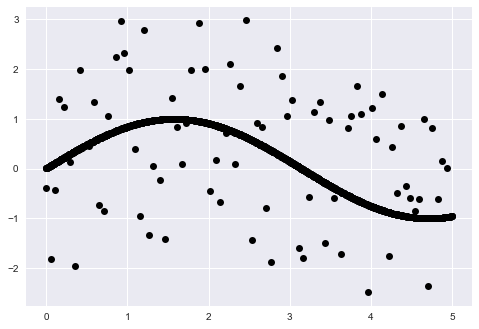

In [5]:
# On augmente le bruit de l'échantillon de départ :
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(2000, 1), axis=0)
y = np.sin(X).ravel()
y[::25] += 5 * (0.5 - rng.rand(80))

plt.plot(X, y, 'o', c="k", label="data")
plt.show()

In [6]:
# On définit une fonction qui, à partir d'un ensemble Train-Test,
# retourne l'erreur quadratique moyenne (Mean Square Error) du Train et du Test
# pour différentes valeurs de profondeur d'arbres

# On passera en paramètre les paramètres du BaggingRegressor permettant de jouer
# sur la taille de l'échantillon Bootstrap et sur la remise ou non après tirage.


def MSE_train_test(X_train, y_train, X_test, y_test,
                   max_samples=1.0, bootstrap=True,
                   tree_max_depth_range=np.arange(1, 11)):

    # Calculate Error on Train & Test for different Tree Depth
    mse_train, mse_test = [], []

    for depth in tree_max_depth_range:
        # Fit Regressor
        tree = DecisionTreeRegressor(max_depth=depth)
        bagging = BaggingRegressor(base_estimator=tree, n_estimators=30,
                                   max_samples=max_samples, bootstrap=bootstrap)
        bagging.fit(X_train, y_train)

        # Predict and Compute Mean Square Error
        y_pred_train = bagging.predict(X_train)
        y_pred_test = bagging.predict(X_test)
        mse_train.append(mean_squared_error(y_train, y_pred_train))
        mse_test.append(mean_squared_error(y_test, y_pred_test))

    return mse_train, mse_test

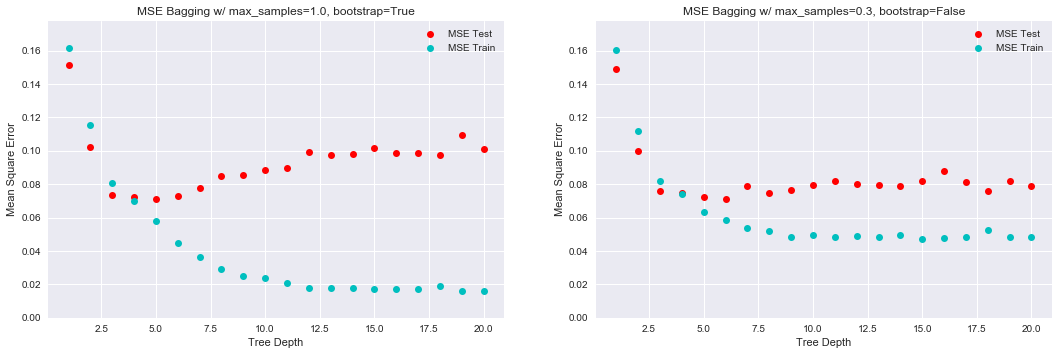

In [7]:
# Split dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.70, random_state=1)

# Plot Error
plt.figure(figsize=(18, 12))

# Range of tree depth
tree_max_depth_range = np.arange(1, 21, 1)

# Bootstrap : taille équivalente à l'échantillon + Avec remise
mse_train, mse_test = MSE_train_test(X_train, y_train, X_test, y_test,
                                     max_samples=1.0, bootstrap=True,
                                     tree_max_depth_range=tree_max_depth_range)

# Bootstrap2 : Sous-echantillonage + Sans Remise
mse_train2, mse_test2 = MSE_train_test(X_train, y_train, X_test, y_test,
                                       max_samples=0.3, bootstrap=False,
                                       tree_max_depth_range=tree_max_depth_range)


mse_total = [mse_train, mse_test, mse_train2, mse_test2]
y_max = np.max(mse_total) + 0.1 * np.max(mse_total)

plt.subplot(2, 2, 1)
plt.plot(tree_max_depth_range, mse_test, 'o', c="r", label="MSE Test")
plt.plot(tree_max_depth_range, mse_train, 'o', c="c", label="MSE Train")
plt.legend(loc='best')
plt.xlabel("Tree Depth")
plt.ylabel("Mean Square Error")
plt.ylim(0, y_max)
plt.title("MSE Bagging w/ max_samples=1.0, bootstrap=True")

plt.subplot(2, 2, 2)
plt.plot(tree_max_depth_range, mse_test2, 'o', c="r", label="MSE Test")
plt.plot(tree_max_depth_range, mse_train2, 'o', c="c", label="MSE Train")
plt.legend(loc='best')
plt.xlabel("Tree Depth")
plt.ylabel("Mean Square Error")
plt.ylim(0, y_max)
plt.title("MSE Bagging w/ max_samples=0.3, bootstrap=False")

plt.show()

> Après avoir fortement bruité l'échantillon, on peut voir sur le graphique de gauche qu'il y a eu sur-apprentissage :  
- En effet, on voit que l'erreur d'apprentissage tend vers zéro lorsque la complexité du modèle augmente (lorsque la profondeur des arbres augmente),  
- Alors que dans le même temps, l'erreur de test augmente.  
      ==> Le modèle a donc du mal à généraliser.
  

> Le graphique de droite nous montre qu'on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons bootstrap.

## <center> - Random Forests -
***

Les forêts aléatoires (en : Random Forests), combinent l’idée du Bagging, l’échantillonnage par bootstrap et moyennage, avec une sélection aléatoire des variables à chaque nœud de la construction de l’arbre. Dans le cas de la classification, l’agrégation se fait par vote majoritaire.

### Question 6.

Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets **boston**, **diabetes**, **iris** et **digits**. Comparez ces performances avec celles d’un SVM linéaire.

In [8]:
# Boston dataset (regression)
X, y = load_boston(return_X_y=True)

rf_reg = RandomForestRegressor()
cv_scores = cross_val_score(rf_reg, X, y, cv=7)
print("[RandomForests] R^2 coeff = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

svr = LinearSVR()
cv_scores = cross_val_score(svr, X, y, cv=7)
print("[Linear SVR]    R^2 coeff = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

[RandomForests] R^2 coeff = 0.639 (+/- 0.337)
[Linear SVR]    R^2 coeff = 0.171 (+/- 1.152)


In [9]:
# Diabetes dataset (regression)
X, y = load_diabetes(return_X_y=True)

rf_reg = RandomForestRegressor()
cv_scores = cross_val_score(rf_reg, X, y, cv=7)
print("[RandomForests] R^2 coeff = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

svr = LinearSVR()
cv_scores = cross_val_score(svr, X, y, cv=7)
print("[Linear SVR]    R^2 coeff = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

[RandomForests] R^2 coeff = 0.351 (+/- 0.173)
[Linear SVR]    R^2 coeff = -0.373 (+/- 0.460)


In [12]:
# Iris dataset (Classification)
X, y = load_iris(return_X_y=True)

rf_class = RandomForestClassifier()
cv_scores = cross_val_score(rf_class, X, y, cv=7)
print("[RandomForests] Accuracy = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

svc = LinearSVC()
cv_scores = cross_val_score(svc, X, y, cv=7)
print("[Linear SVC]    Accuracy = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

[RandomForests] Accuracy = 0.946 (+/- 0.080)
[Linear SVC]    Accuracy = 0.952 (+/- 0.169)


In [13]:
# Digits dataset (Classification)
X, y = load_digits(return_X_y=True)

rf_class = RandomForestClassifier()
cv_scores = cross_val_score(rf_class, X, y, cv=7)
print("[RandomForests] Accuracy = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

svc = LinearSVC()
cv_scores = cross_val_score(svc, X, y, cv=7)
print("[Linear SVC]    Accuracy = %0.3f (+/- %0.3f)" %
      (cv_scores.mean(), cv_scores.std() * 2))

[RandomForests] Accuracy = 0.896 (+/- 0.080)
[Linear SVC]    Accuracy = 0.906 (+/- 0.078)


> En utilisant les paramètres par défaut pour le RandomForest et le SVM Linéaire, on constate que :
- En régression (Diabetes & Boston) : le Random Forest est plus performant que le SVM
- En classification (Iris & Digits) : les deux modèles sont pratiquement aussi performants (avec un léger avantage pour le SVM)

> En réalité, si l'on voulait comparer le plus objectivement possible la performance de ces deux modèles , il faudrait prendre le temps, pour chacun des modèles, de choisir les paramètres qui maximisent le score.

### Question 7.

En utilisant le dataset **iris** restreint aux deux premières variables explicatives, afficher la probabilité de prédiction des classes. On partira du script suivant et on fera varier le nombre d’arbres aléatoires (variable n_estimators).

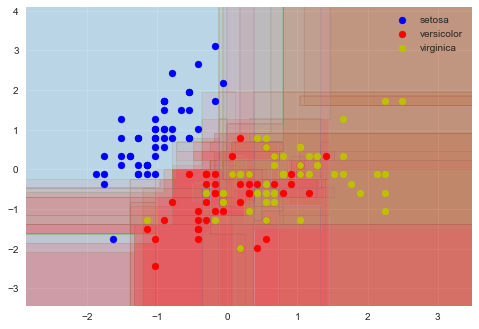

In [14]:
# Parameters
n_estimators = 10
plot_colors = "bry"
plot_step = 0.02
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target
# Standardize
X = preprocessing.scale(X_unscaled)
# RF fitting
model = RandomForestClassifier(n_estimators=n_estimators)
clf = model.fit(X, y)

# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
X_mesh = np.c_[xx.ravel(), yy.ravel()]

plt.figure()
for tree in model.estimators_:
    # TODO use predict to obtain the probabilities you will store in Z
    Z = tree.predict(X_mesh)
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=1. / n_estimators, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, c in zip(range(3), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i], cmap=plt.cm.Paired)
plt.legend(scatterpoints=1)
plt.show()

### Question 8.

Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions pures (obtenus avec DecisionTreeClassifier), sur le dataset **iris** restreint aux deux premières variables explicatives. On fera varier le paramètre max_depth entre $1$ et $30$. Mettre en évidence le fait que les Random Forests permettent de réduire le sur-apprentissage, et ce même pour des arbres profonds.

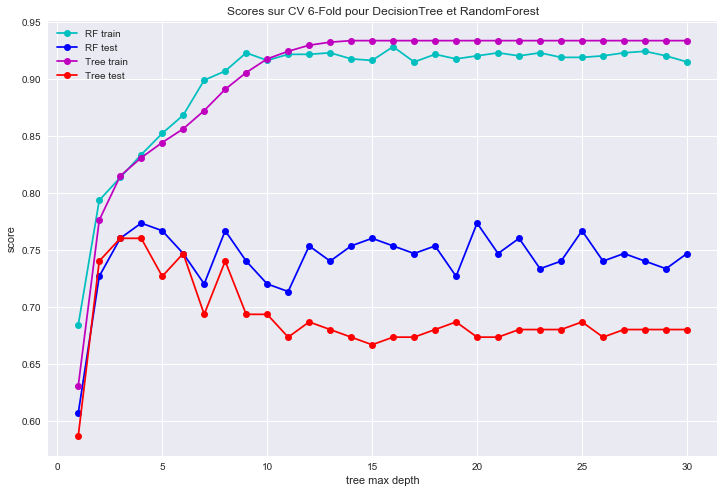

In [15]:
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target
# Standardize
X = preprocessing.scale(X_unscaled)

# Shuffle on DataBase rows
X, y = shuffle(X, y) #, random_state=0)

# Compute CV-Scores for different tree depth
tree_depth_range = np.arange(1, 31)
scores_RF_train = np.zeros_like(tree_depth_range, dtype='float64')
scores_RF_test = np.zeros_like(tree_depth_range, dtype='float64')
scores_DT_train = np.zeros_like(tree_depth_range, dtype='float64')
scores_DT_test = np.zeros_like(tree_depth_range, dtype='float64')

for d in tree_depth_range:
    
    n_splits = 6
    kf = KFold(n_splits=n_splits, random_state=0)
    dt_train_score_kfold= np.empty(n_splits, dtype='float64')
    dt_test_score_kfold = np.empty(n_splits, dtype='float64')
    rf_train_score_kfold = np.empty(n_splits, dtype='float64')
    rf_test_score_kfold = np.empty(n_splits, dtype='float64')

    for i, (train, test) in enumerate(kf.split(X)):

        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        # Fit on Train, Compute Train & Test scores
        dt = DecisionTreeClassifier(max_depth=d)
        dt.fit(X_train, y_train)
        dt_train_score_kfold[i] = dt.score(X_train, y_train)
        dt_test_score_kfold[i] = dt.score(X_test, y_test)
        
        rf = RandomForestClassifier(max_depth=d)
        rf.fit(X_train, y_train)
        rf_train_score_kfold[i] = rf.score(X_train, y_train)
        rf_test_score_kfold[i] = rf.score(X_test, y_test)
    
    # For the different folds, compute mean scores
    scores_DT_train[d-1] = dt_train_score_kfold.mean()
    scores_DT_test[d-1] = dt_test_score_kfold.mean()
    scores_RF_train[d-1] = rf_train_score_kfold.mean()
    scores_RF_test[d-1] = rf_test_score_kfold.mean()

# Plot scores
plt.figure(figsize=(12, 8))
plt.plot(tree_depth_range, scores_RF_train, label='RF train', linestyle='-', marker='o', c='c')
plt.plot(tree_depth_range, scores_RF_test, label='RF test', linestyle='-', marker='o', c='b')
plt.plot(tree_depth_range, scores_DT_train, label='Tree train', linestyle='-', marker='o', c='m')
plt.plot(tree_depth_range, scores_DT_test, label='Tree test', linestyle='-', marker='o', c='r')
plt.xlabel('tree max depth')
plt.ylabel('score')
#plt.ylim(0, 1)
plt.legend()
plt.title('Scores sur CV 6-Fold pour DecisionTree et RandomForest')
plt.show()

> En comparant les résultats obtenus sur les données de Test, on peut voir que les scores par CV 6-fold sont meilleurs en Random Forest qu'en Decision Tree, quelquesoit la profondeur des arbres.  

> De plus, l'écart entre les courbes de Train et de Test est plus faible sur les Random Forests que sur les Decision Trees, ce qui montre que les Random Forests permettent de réduire le sur-apprentissage.

## <center> - Boosting -
***


### Question 9.

Démontrez la propriété suivante:
Le minimiseur de  la fonction $f\to R_{\exp}(f)=\mathbb{E}(\exp(-Yf(x)))$
est atteint en  $f_{\exp}^* =\frac{1}{2}\log \big( \frac{\eta(x)}{1-\eta(x)} \big) $

$\newcommand{dd}{\:\mathrm{d}}$
- #### Etape 0 : Notons la fonction $\mathbb{E}\left[ \exp(-Yf(x)) \right] : \mathbb{E}_{X,Y}\left[ \ell(Y, f(X)) \right]$ avec $\ell(y, f(x))=\exp(-y \cdot f(x))$

- #### Etape 1 : Montrons que $\mathbb{E}_{X,Y}\left[ \ell(Y, f(X)) \right] = \mathbb{E}_{X}\left[ \ \mathbb{E}_{Y \mid X} \left[ \ell(Y, f(X)) \mid X=x \right] \ \right] $
> $ \kern 9pc\mathbb{E}_{X,Y}\left[ \ell(Y, f(X)) \right]$
$ = \int_x{ \int_y{\ell(y, f(x)) \dd \mathbb{P}_{X,Y}(x,y)} }
\kern 1pc \text{or} \kern 1pc
\dd\mathbb{P}_{X,Y}(x,y) = \dd\mathbb{P}_{Y \mid X=x}(y) \cdot \dd\mathbb{P}_{X}(x) \\
= \int_x \left[ \int_y{\ell(y, f(x)) \dd\mathbb{P}_{Y \mid X=x}(y)} \right] \dd\mathbb{P}_{X}(x) \\
= \mathbb{E}_{X}\left[ \ \mathbb{E}_{Y \mid X} \left[ \ell(Y, f(X)) \mid X=x \right] \ \right]
$
  
  
- #### Etape 2 : Notons $f^*(x)$ la fonction suivante : $\ f^*(x) = \underset{a}{\arg\min} \int_y{\ell(y, a) \dd\mathbb{P}_{Y \mid X=x}(y)} $
  
  
- #### Etape 3: Vérifions que cette fonction $f^*$ est bien un minimisateur du risque empirique
> \begin{equation}
\begin{split}
\int_y{\ell(y, f^*(x))\dd\mathbb{P}_{Y \mid X=x}(y)}
& \leq
\int_y{\ell(y, f(x))\dd\mathbb{P}_{Y \mid X=x}(y)} \kern 1pc \text{(puisque $f^*$ est un minimum)} \\
\int_x \left[ \int_y{\ell(y, f^*(x))\dd\mathbb{P}_{Y \mid X=x}(y)} \right] \dd\mathbb{P}_{X}(x)
& \leq
\int_x \left[ \int_y{\ell(y, f(x))\dd\mathbb{P}_{Y \mid X=x}(y)} \right] \dd\mathbb{P}_{X}(x) \\
\mathbb{E}_{X}\left[ \ \mathbb{E}_{Y \mid X} \left[ \ell(Y, f^*(X)) \mid X=x \right] \ \right]
& \leq
\mathbb{E}_{X}\left[ \ \mathbb{E}_{Y \mid X} \left[ \ell(Y, f(X)) \mid X=x \right] \ \right] \\
\mathbb{E}_{X,Y}\left[ \ell(Y, f^*(X)) \right]
& \leq
\mathbb{E}_{X,Y}\left[ \ell(Y, f(X)) \right] \\
R(f^*) & \leq R(f)
\end{split}
\end{equation}


- #### Etape 4: Calculons $f^*$ dans le cas où $\ell(y, f(x))=\exp{(-y \cdot f(x))}$

  Rappel : $ \mathbb{P}(Y=+1 \mid X=x) = \eta(x) \\
\mathbb{P}(Y=-1 \mid X=x) = 1 - \eta(x)$

  > \begin{equation}
  \begin{split}
  f^*(x) & = \underset{a}{\arg\min} \int_y{\ell(y, a) \dd\mathbb{P}_{Y \mid X=x}(y)} \kern 1pc \text{or $Y$ ne prend que deux valeurs : \{ -1 ; 1 \} } \\
  & = \underset{a}{\arg\min} \left[ \  \ell(1, a) \cdot \mathbb{P}(Y=1 \mid X=x) \ \ + \ \ \ell(-1, a) \cdot \mathbb{P}(Y=-1 \mid X=x) \ \right] \\
  & = \underset{a}{\arg\min} \left[ \ \ell(1, a) \cdot \eta(x) \ \ + \ \ \ell(-1, a) \cdot (1-\eta(x)) \ \right]
  \end{split}
  \end{equation}

  Soit, dans le cas où $\ell(y, f(x))=\exp(-y \cdot f(x))$ :

  > $$ \kern -7pc f^*(x) =  \underset{a}{\arg\min} \left[ \ \exp(-f(x)) \cdot \eta(x) \ \ + \ \ \exp(f(x)) \cdot (1-\eta(x)) \ \right]
$$  
  
  Pour trouver la fonction qui minimise l'expression précédente, on dérive par rapport à $f$ et on trouve la fonction qui annule la dérivée :
  > $$ -\exp(-f^*) \ \eta(x) + \exp(f^*) \ (1-\eta(x)) = 0 \\
\exp(2f^*) = \frac{\eta(x)}{1-\eta(x)} \\
f^* =\frac{1}{2}\log \big( \frac{\eta(x)}{1-\eta(x)} \big)
$$

### Question 10.

En déduire que le classifieur de Bayes associé au risque $R_{\exp}$ est le même que le classifieur de Bayes associé au
risque $0/1$,  $R_{\varphi_0}$

> Le classifieur de Bayes associé au risque $R_{\exp}$ est le même que le classifieur de Bayes associé au
risque $0/1$ si :
$$ \forall x, \mathrm{sign} \Big( \frac{1}{2}\log \big( \frac{\eta(x)}{1-\eta(x)} \big) \Big) = \mathrm{sign} \big( 2\eta(x)-1 \big)
$$
Démonstration :
\begin{equation}
\begin{split}
\mathrm{sign} \Big( \frac{1}{2}\log \big( \frac{\eta(x)}{1-\eta(x)} \big) \Big) 
& = \mathrm{sign} \Big( \log \big( \frac{\eta(x)}{1-\eta(x)} \big) \Big) \\
& = \text{positif si } \frac{\eta(x)}{1-\eta(x)} > 1 \text{, négatif sinon } \\
& = \text{positif si } 2\eta(x)-1 > 0 \text{, négatif sinon } \\
& = \mathrm{sign} \big( 2\eta(x)-1 \big)
\end{split}
\end{equation}

## <center> - Adaboost -
***

### Question 11.

Montrer que la solution du dernier programme d'optimisation est:
$c_m =\frac{1}{2} \log \left[\frac{{\mathbb{P}}_{\omega^{m-1}}(Y= \widehat{h}_m(X))}{{\mathbb{P}}_{\omega^{m-1}}(Y \neq \widehat{h}_m(X))} \right]$

> On cherche ici à minimiser en $c$ le terme : $\ \ \ \underset{c \in \mathbf{R}}{\arg\min} \ \mathbb{E}_{\omega^{m-1}} \left[e^{-c\cdot Y\cdot \widehat{h}_m(X)} \right] = \sum_{i} \omega_{i}^{m-1} e^{-c\cdot Y_{i}\cdot \widehat{h}_m(X_{i})} $

> On trouve le minimum lorsque la dérivée en $c$ s'annule :
\begin{equation}
\begin{split}
\dfrac{\dd}{\dd c} \big(\sum_{i}{  \omega_{i}^{m-1} e^{-c\cdot Y_{i}\cdot \widehat{h}_m(X_{i})}  } \big)
& = 0 \\
\sum_{i} \omega_{i}^{m-1} \big( -Y_{i} \cdot \widehat{h}_m(X_{i}) \big) \ e^{-c \cdot Y_{i}\cdot \widehat{h}_m(X_{i})}
& = 0 \\
 & \\
\text{or } Y_{i}\widehat{h}_m(X_{i}) = +1 \text{ quand } Y_i=\widehat{h}_m(X_i) \text{ c-à-d quand x est bien classé }
& \text{ et }  Y_{i} \widehat{h}_m(X_{i}) = -1 \text{ sinon} \\
 & \\
\sum_{i: \, Y_i=\widehat{h}_m(X_i)} \omega_{i}^{m-1} (-1) \ e^{-c(1)} \ \ + \sum_{i: \, Y_i\neq\widehat{h}_m(X_i)} \omega_{i}^{m-1} (1) \ e^{-c(-1)}
& = 0 \\
- \sum_{i: \, Y_i=\widehat{h}_m(X_i)} \omega_{i}^{m-1} \ e^{-c} \ \ + \sum_{i: \, Y_i\neq\widehat{h}_m(X_i)} \omega_{i}^{m-1} \ e^{c}
& = 0
\end{split}
\end{equation}

> Or $ \sum_{i: \, Y_i=\widehat{h}_m(X_i)} \omega_{i}^{m-1} = \mathbb{P}_{\omega^{m-1}}(Y= \widehat{h}_m(X)) $  
et $ \sum_{i: \, Y_i\neq\widehat{h}_m(X_i)} \omega_{i}^{m-1} = \mathbb{P}_{\omega^{m-1}}(Y \neq \widehat{h}_m(X)) $  

> donc :
\begin{equation}
\begin{split}
\sum_{i: \, Y_i=\widehat{h}_m(X_i)} \omega_{i}^{m-1} \ e^{-c}
& = \sum_{i: \, Y_i\neq\widehat{h}_m(X_i)} \omega_{i}^{m-1} \ e^{c} \\
\mathbb{P}_{\omega^{m-1}}(Y= \widehat{h}_m(X)) \ e^{-c}
& = \mathbb{P}_{\omega^{m-1}}(Y \neq \widehat{h}_m(X)) \ e^{c} \\
\frac{\mathbb{P}_{\omega^{m-1}}(Y= \widehat{h}_m(X))}{\mathbb{P}_{\omega^{m-1}}(Y \neq \widehat{h}_m(X))}
& = e^{2c} \\
\frac{1}{2} \log \left[\frac{{\mathbb{P}}_{\omega^{m-1}}(Y= \widehat{h}_m(X))}{{\mathbb{P}}_{\omega^{m-1}}(Y \neq \widehat{h}_m(X))} \right]
& = c
\end{split}
\end{equation}





### Question 12.

Montrer que les poids $\omega^{m}_i \propto \omega^{m-1}_i \cdot \exp(-c_m^* \cdot Y_i  \cdot \hat{h}_{m}(X_i))$ (où $c_m^*$ est défini ci-dessus) et les poids $w^m_i\propto w^{m-1}_i\cdot \exp(2 \cdot c_m \cdot \mathbf{1}_{\{Y_i \neq
  \hat{h}_m(X_i) \}})$ (où $c_m$ est défini dans l'algorithme
AdaBoost) sont identiques, avec la convention $\hat F_0=0$ et $w^0 = \omega^0 = (\frac{1}{n}, \cdots,\frac{1}{n})$.

### Question 13.

Mettre en œuvre AdaBoost avec des arbres de profondeur $1$, puis $2$, puis $10$, sur le jeu de données **digits**.  
On calculera notamment la précision obtenue par 6-fold cross-validation.

In [16]:
# Load data
digits = load_digits()
X, y = digits.data, digits.target

for depth in [1, 2, 10]:
    tree = DecisionTreeClassifier(max_depth=depth)
    ada = AdaBoostClassifier(tree, n_estimators=50,
                             learning_rate=1.0, algorithm='SAMME.R')
    score = np.mean(cross_val_score(ada, X, y, cv=6))
    print("[Profondeur d'arbres: %d] Score = %f" % (depth, score))

[Profondeur d'arbres: 1] Score = 0.264185
[Profondeur d'arbres: 2] Score = 0.595884
[Profondeur d'arbres: 10] Score = 0.955512


### Question 14.

Appliquer AdaBoost sur les données **digits** découpées en deux échantillons : apprentissage (75%) et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations.

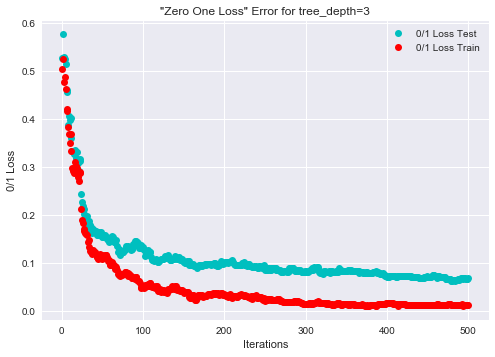

In [18]:
# Load data
digits = load_digits()
X, y = digits.data, digits.target

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# AdaBoost
n_estimators=500
tree = DecisionTreeClassifier(max_depth=3)
ada = AdaBoostClassifier(tree, n_estimators=n_estimators, learning_rate=1.0, algorithm='SAMME.R')

ada.fit(X_train, y_train)

train_errors = []
test_errors = []

for y_pred_train in ada.staged_predict(X_train):
    train_errors.append(zero_one_loss(y_train, y_pred_train))

for y_pred_test in ada.staged_predict(X_test):
    test_errors.append(zero_one_loss(y_test, y_pred_test))

# Plot Scores
plt.plot(range(1, n_estimators+1), test_errors, 'o', c="c", label="0/1 Loss Test")
plt.plot(range(1, n_estimators+1), train_errors, 'o', c="r", label="0/1 Loss Train")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("0/1 Loss")
#plt.ylim(0,1)
plt.title('"Zero One Loss" Error for tree_depth=3')
plt.show()

### Question 15.

Que remarquez vous ? Que se passe-t-il si la profondeur des arbres de classification est grande ?

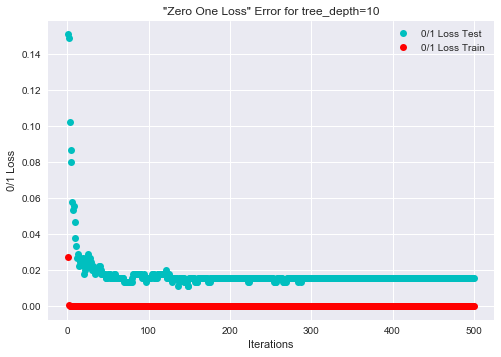

In [19]:
# We use the same split as previous

## Load data
#digits = load_digits()
#X, y = digits.data, digits.target
#
## Train Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# AdaBoost
n_estimators=500
tree = DecisionTreeClassifier(max_depth=10)
ada = AdaBoostClassifier(tree, n_estimators=n_estimators, learning_rate=1.0, algorithm='SAMME.R')

ada.fit(X_train, y_train)

train_errors = []
test_errors = []

for y_pred_train in ada.staged_predict(X_train):
    train_errors.append(zero_one_loss(y_train, y_pred_train))

for y_pred_test in ada.staged_predict(X_test):
    test_errors.append(zero_one_loss(y_test, y_pred_test))

# Plot Scores
plt.plot(range(1, n_estimators+1), test_errors, 'o', c="c", label="0/1 Loss Test")
plt.plot(range(1, n_estimators+1), train_errors, 'o', c="r", label="0/1 Loss Train")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("0/1 Loss")
#plt.ylim(0, 0,5)
plt.title('"Zero One Loss" Error for tree_depth=10')
plt.show()

> Avec des arbres plus profonds (ici profondeur = 10), on remarque que l'algo Adaboost converge plus rapidement qu'avec des arbres peu profonds.  

> De plus, cela a fortement réduit les erreurs 0/1. Il faudrait tout de même regarder ces mêmes résultats en faisant varier la profondeur des arbres pour vérifier si ces très faibles valeurs d'erreurs ne proviennent pas d'un sur-apprentissage...